In [1]:
from langgraph.graph import StateGraph,START,MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from dotenv import load_dotenv
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.messages import RemoveMessage,HumanMessage

In [2]:
load_dotenv()

True

In [4]:
model = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    task="text-generation"
)

llm = ChatHuggingFace(llm=model)

In [5]:
class ChatState(MessagesState):
    summary: str
    

In [ ]:
def chat_node(state: ChatState):

    messages = []

    if state['summary']:
        messages.append({
            "role":"system",
            "content": f"Conversation summary: \n {state['summary']}"
        })

    messages.extend(state['messages'])

    # print(messages)

    response = llm.invoke(messages)

    return {'messages':[response]}

In [7]:
def summarize_conversation(state: ChatState):

    existing_summary = state['summary']

    if existing_summary:
        prompt = {
            f"Existing Summary:\n{existing_summary}\n\n"
            "Extent the summary using the new conversation above."
        }
    else:
        prompt = "Summarize the conversation above"
    
    messages_for_summary = state['messages'] + [HumanMessage(content=prompt)]

    response = llm.invoke(messages_for_summary)

    message_to_delete = state['messages'][:-2]

    return {
        "summary": response.content,
        "messages":[RemoveMessage(id=m.id) for m in message_to_delete]
    }

In [8]:
def should_summarize(state: ChatState):
    return len(state['messages']) > 6

In [10]:
builder = StateGraph(ChatState)

builder.add_node('chat',chat_node)
builder.add_node('summarize',summarize_conversation)

builder.add_edge(START,'chat')

builder.add_conditional_edges('chat',should_summarize,{True:"summarize",False:"__end__"})

builder.add_edge('summarize','__end__')

In [11]:
graph = builder.compile(checkpointer=InMemorySaver())

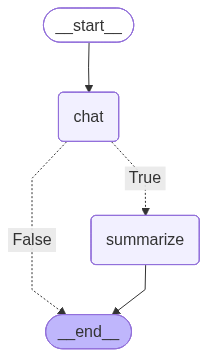

In [12]:
graph

In [16]:
config = {'configurable':{'thread_id':'t1'}}

In [17]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [ ]:
out = graph.invoke({"messages":[HumanMessage(content="Quantum Physics")],'summary':''},config)
print(out)
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9fddded3-8a8a-46d2-830a-70d34c21631b')]
{'messages': [HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9fddded3-8a8a-46d2-830a-70d34c21631b'), AIMessage(content=' Quantum physics, also known as quantum mechanics, is a branch of physics that deals with phenomena on a very small scale, such as molecules, atoms, and subatomic particles like electrons, protons, and photons. It is a fundamental theory in physics which describes nature at the smallest scales of energy levels of atoms and subatomic particles.\n\nOne of the key differences between classical physics and quantum physics is the behavior of energy. In classical physics, energy is a continuous property; it can take on any value. In quantum physics, energy is quantized, meaning it can only take on certain discrete values.\n\nAnother important concept in quantum physics is the wave-particle duality. This pri

In [19]:
out = graph.invoke({"messages":[HumanMessage(content="How is Albert Einstein related?")],'summary':''},config)
print(out)
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9fddded3-8a8a-46d2-830a-70d34c21631b'), AIMessage(content=' Quantum physics, also known as quantum mechanics, is a branch of physics that deals with phenomena on a very small scale, such as molecules, atoms, and subatomic particles like electrons, protons, and photons. It is a fundamental theory in physics which describes nature at the smallest scales of energy levels of atoms and subatomic particles.\n\nOne of the key differences between classical physics and quantum physics is the behavior of energy. In classical physics, energy is a continuous property; it can take on any value. In quantum physics, energy is quantized, meaning it can only take on certain discrete values.\n\nAnother important concept in quantum physics is the wave-particle duality. This principle states that every particle has both wave-like and particle-like properties. For example, light can behave as both a particle and a wave

In [20]:
out = graph.invoke({"messages":[HumanMessage(content="What are some of Einstein's famous works")],'summary':''},config)
print(out)
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9fddded3-8a8a-46d2-830a-70d34c21631b'), AIMessage(content=' Quantum physics, also known as quantum mechanics, is a branch of physics that deals with phenomena on a very small scale, such as molecules, atoms, and subatomic particles like electrons, protons, and photons. It is a fundamental theory in physics which describes nature at the smallest scales of energy levels of atoms and subatomic particles.\n\nOne of the key differences between classical physics and quantum physics is the behavior of energy. In classical physics, energy is a continuous property; it can take on any value. In quantum physics, energy is quantized, meaning it can only take on certain discrete values.\n\nAnother important concept in quantum physics is the wave-particle duality. This principle states that every particle has both wave-like and particle-like properties. For example, light can behave as both a particle and a wave

In [21]:
out = graph.invoke({"messages":[HumanMessage(content="Explain Special Theory of Relativity")],'summary':''},config)
print(out)
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9fddded3-8a8a-46d2-830a-70d34c21631b'), AIMessage(content=' Quantum physics, also known as quantum mechanics, is a branch of physics that deals with phenomena on a very small scale, such as molecules, atoms, and subatomic particles like electrons, protons, and photons. It is a fundamental theory in physics which describes nature at the smallest scales of energy levels of atoms and subatomic particles.\n\nOne of the key differences between classical physics and quantum physics is the behavior of energy. In classical physics, energy is a continuous property; it can take on any value. In quantum physics, energy is quantized, meaning it can only take on certain discrete values.\n\nAnother important concept in quantum physics is the wave-particle duality. This principle states that every particle has both wave-like and particle-like properties. For example, light can behave as both a particle and a wave